In [21]:
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torch.utils.data as data_utils
from tqdm.notebook import tqdm as tqdm
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import utils
import torch.nn as nn
import numpy as np
import os, imageio
import pickle
import torch
import random


In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

torch.set_default_dtype(torch.float64)
torch.set_default_device(device)

Using PyTorch version: 2.1.0.dev20230622+cu121  Device: cuda


## Dataloader

In [3]:
def dataset_loader(dataset_name,d_path,gen):

  if dataset_name == "mnist":
    mnist_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1.0),
    transforms.CenterCrop((28))
    ])

    dataset = datasets.MNIST(root=os.path.join(d_path,'datasets'), train=True,download=True, transform=mnist_trans)


  if dataset_name == "cifar":
    cifar_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(0, 1.0),
    transforms.CenterCrop((28))
    ])

    dataset = datasets.CIFAR10(root=os.path.join(d_path,'datasets'), train=True,
                                        download=True, transform=cifar_trans)

  return torch.utils.data.random_split(dataset, [10000, len(dataset)-10000],generator=gen)[0] # gets split into two parts [10k and 50k]



In [4]:
def generate_pixel_coordinates(img):

    height, width, _ = img.permute(1,2,0).shape

    # Generate coordinates along the x-axis and y-axis
    x_coords = np.linspace(0, 1, width, endpoint=False)
    y_coords = np.linspace(0, 1, height, endpoint=False)

    # Create a meshgrid of coordinates
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)

    # Stack the coordinates and reshape to obtain the final output
    coordinates = np.stack([x_mesh, y_mesh], axis=-1)

    return coordinates

In [10]:
def input_mapping(x, B):
    '''
        cos and sin of input are joined together to increased the dimension to 4.
    '''
    if B is None:
        return x
    else:
        B = B.to(x)
        x_proj = (2.*np.pi*x) @ B.T #512,2
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)    #  2*len(B) #512,4

In [11]:
def batch_loader(coord_input,image):

    coord_input = input_mapping(coord_input, map_dict[mapping])

    test_data = [coord_input, image]
    train_data = [coord_input[::2], image[::2]]

    train_x = torch.tensor(train_data[0])#.reshape(-1,coord_input.shape[2]) # because input has 4 dimension
    train_y = torch.tensor(train_data[1])#.reshape(-1,3)
    test_x = torch.tensor(test_data[0])#.reshape(-1,coord_input.shape[2]) # because input has 4 dimension
    test_y = torch.tensor(test_data[1])#.reshape(-1,3)

    return train_x,train_y,test_x,test_y

### Model

In [5]:
class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50) # input has 4 dimensions.
        self.fc1_drop = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50,1)

    def forward(self, x):
        # x = x.view(-1,4) # input has 4 dimensions.
        x = self.relu1(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.relu2(self.fc2(x))
        x = self.fc2_drop(x)
        return self.fc3(x)

### Train

In [13]:
def model_weights(coordinates,image,img_no,d_path,save = False):

    train_x,train_y,test_x,test_y = batch_loader(coordinates,image.permute(1,2,0))

    input = test_x.to(device)
    target = test_y.to(device)
    
    model = Net(input.shape[2]).to(device)
            
    optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-2)

    ep = 1501
    
    for epoch in range(ep):
        
        optimizer.zero_grad()

        # print(input.shape)
        generated = model(input)
        # print(model)
        loss = torch.nn.functional.l1_loss(target, generated)

        loss.backward()
        optimizer.step()

        # if epoch % 300 == 0:
        #     print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
        #     plt.imshow(generated.detach().cpu().numpy(),cmap='gray')
        #     plt.show()
    
    if save:
        torch.save(model.state_dict(), os.path.join(d_path,'weights\{fname}.pth'.format(fname=img_no)))
        # plt.imshow(generated.detach().cpu().numpy(),cmap='gray')
        # plt.show()
        # print(generated.shape)
        
        
        save_image(generated.permute(2,0,1), os.path.join(d_path,'reconstructed_images\{fname}.png'.format(fname=img_no)))

    torch.cuda.empty_cache()
    del model

    return loss

### Main


In [7]:
dataset_name = "mnist"
method_type = "non-fourier"
generator_rand = torch.Generator(device = device).manual_seed(42)

In [8]:
if dataset_name == "cifar":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\cifar"
    if method_type == "non-fourier":
        dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\cifar"
    
if dataset_name == "mnist":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist"
    if method_type == "non-fourier":
        dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist" 

In [9]:
dataset_path

'C:\\Users\\ayush\\OneDrive\\Desktop\\UoE\\Dissertation\\non-fourier\\data\\mnist'

In [16]:
dataset = dataset_loader(dataset_name,dataset_path,generator_rand)

100%|██████████| 9912422/9912422 [00:00<00:00, 15310450.20it/s]


Extracting C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist\datasets\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist\datasets\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 23304288.92it/s]

Extracting C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist\datasets\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist\datasets\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9407801.68it/s]


Extracting C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist\datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist\datasets\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist\datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist\datasets\MNIST\raw



In [35]:
mapping_size = 64

B_dict = {}

B_gauss = torch.normal(0,1,size=(mapping_size,2))
for scale in [10.]:
    B_dict[f'gauss_{scale}'] = B_gauss * scale

for k in B_dict:
    keys = k

In [17]:
x,_ = dataset[0]

xy_grid = torch.from_numpy(generate_pixel_coordinates(x))

In [18]:
labels = [dataset[i][1] for i in range(len(dataset))]

In [19]:
torch.save(dataset,os.path.join(dataset_path,"datasets",dataset_name+'_10K_dataset.pt'))

with open(os.path.join(dataset_path,"datasets",dataset_name+"_labels"), "wb") as fp:   #Pickling
  pickle.dump(labels, fp)

# for layer in model.children():
#     if hasattr(layer, 'reset_parameters'):
#         layer.reset_parameters()

In [ ]:
# for index in tqdm(range(2)):
#         model_weights(xy_grid,dataset[index][0],index,dataset_path,save=True)

## Flatten Weights Dict

In [10]:
def flatten_weights(img_no):

  path = os.path.join(dataset_path,'weights\{fname}.pth'.format(fname=img_no))

  model.load_state_dict(torch.load(path))

  weights = []

  for param in model.parameters():

    weights.extend(list(torch.flatten(param.data).detach().cpu().numpy()))

  return np.array(weights)


In [11]:
model = Net(2)
weights_dict = {}

for i in range(10000):

  weights_dict[str(i)] = flatten_weights(i)

In [12]:
dataset_path

'C:\\Users\\ayush\\OneDrive\\Desktop\\UoE\\Dissertation\\non-fourier\\data\\mnist'

In [ ]:
with open(os.path.join(dataset_path,'datasets','weights_dictionary.pkl'), 'wb') as f:
    pickle.dump(weights_dict, f)

## Exploring

In [31]:
model = Net(128)
img_no = 1

path = os.path.join(dataset_path,'weights\{fname}.pth'.format(fname=img_no))

model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [32]:
for param in model.parameters():

    print(param.shape)

torch.Size([50, 2])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([1, 50])
torch.Size([1])


## Loss 

In [6]:
plt.style.use('seaborn-whitegrid')  

# plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 15
# plt.rcParams['axes.labelweight'] = ''
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] =15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 40

In [20]:
loss_mnist_with_fourier = []

for index in tqdm(range(len(dataset))):
        loss_mnist_with_fourier.append(model_weights(xy_grid,dataset[index][0],index,dataset_path,save=True).detach().cpu().numpy())


with open(dataset_path+"\experiments\cross_entro_loss_10K_images_without_fourier.pkl",'wb') as f:

    pickle.dump(loss_mnist_with_fourier,f)

with open(dataset_path+"\experiments\cross_entro_loss_10K_images_without_fourier.pkl",'rb') as f:

    loss_mnist_saved = pickle.load(f)

  0%|          | 0/10000 [00:00<?, ?it/s]

c:\MLAI\lib\site-packages\torch\utils\_device.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [53]:
# with open(dataset_path+"\experiments\cross_entro_loss_10K_images_without_fourier.pkl",'wb') as f:

#     pickle.dump(loss_mnist_with_fourier,f)

with open(r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\mnist\experiments\cross_entro_loss_10K_images_without_fourier.pkl",'rb') as f:

    loss_mnist_vanilla = pickle.load(f)

with open(r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\mnist\experiments\cross_entro_loss_10K_images_without_fourier.pkl",'rb') as f:

    loss_mnist_fourier = pickle.load(f)

with open(r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\non-fourier\data\cifar\experiments\cross_entro_loss_10K_images_without_fourier.pkl",'rb') as f:

    loss_cifar_vanilla = pickle.load(f)

with open(r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\cifar\experiments\cross_entro_loss_10K_images_without_fourier.pkl",'rb') as f:

    loss_cifar_fourier = pickle.load(f)


In [47]:
new_loss_cifar_fourier = []

In [76]:
print(np.average(loss_cifar_vanilla),np.average(loss_cifar_fourier),np.average(loss_mnist_fourier),np.average(loss_mnist_vanilla))

0.07137753145433447 0.028076542221129357 0.017142774958280024 0.09326447761011493


In [48]:
for i in range(50):

    new_loss_cifar_fourier.extend(random.sample(loss_cifar_fourier,200))

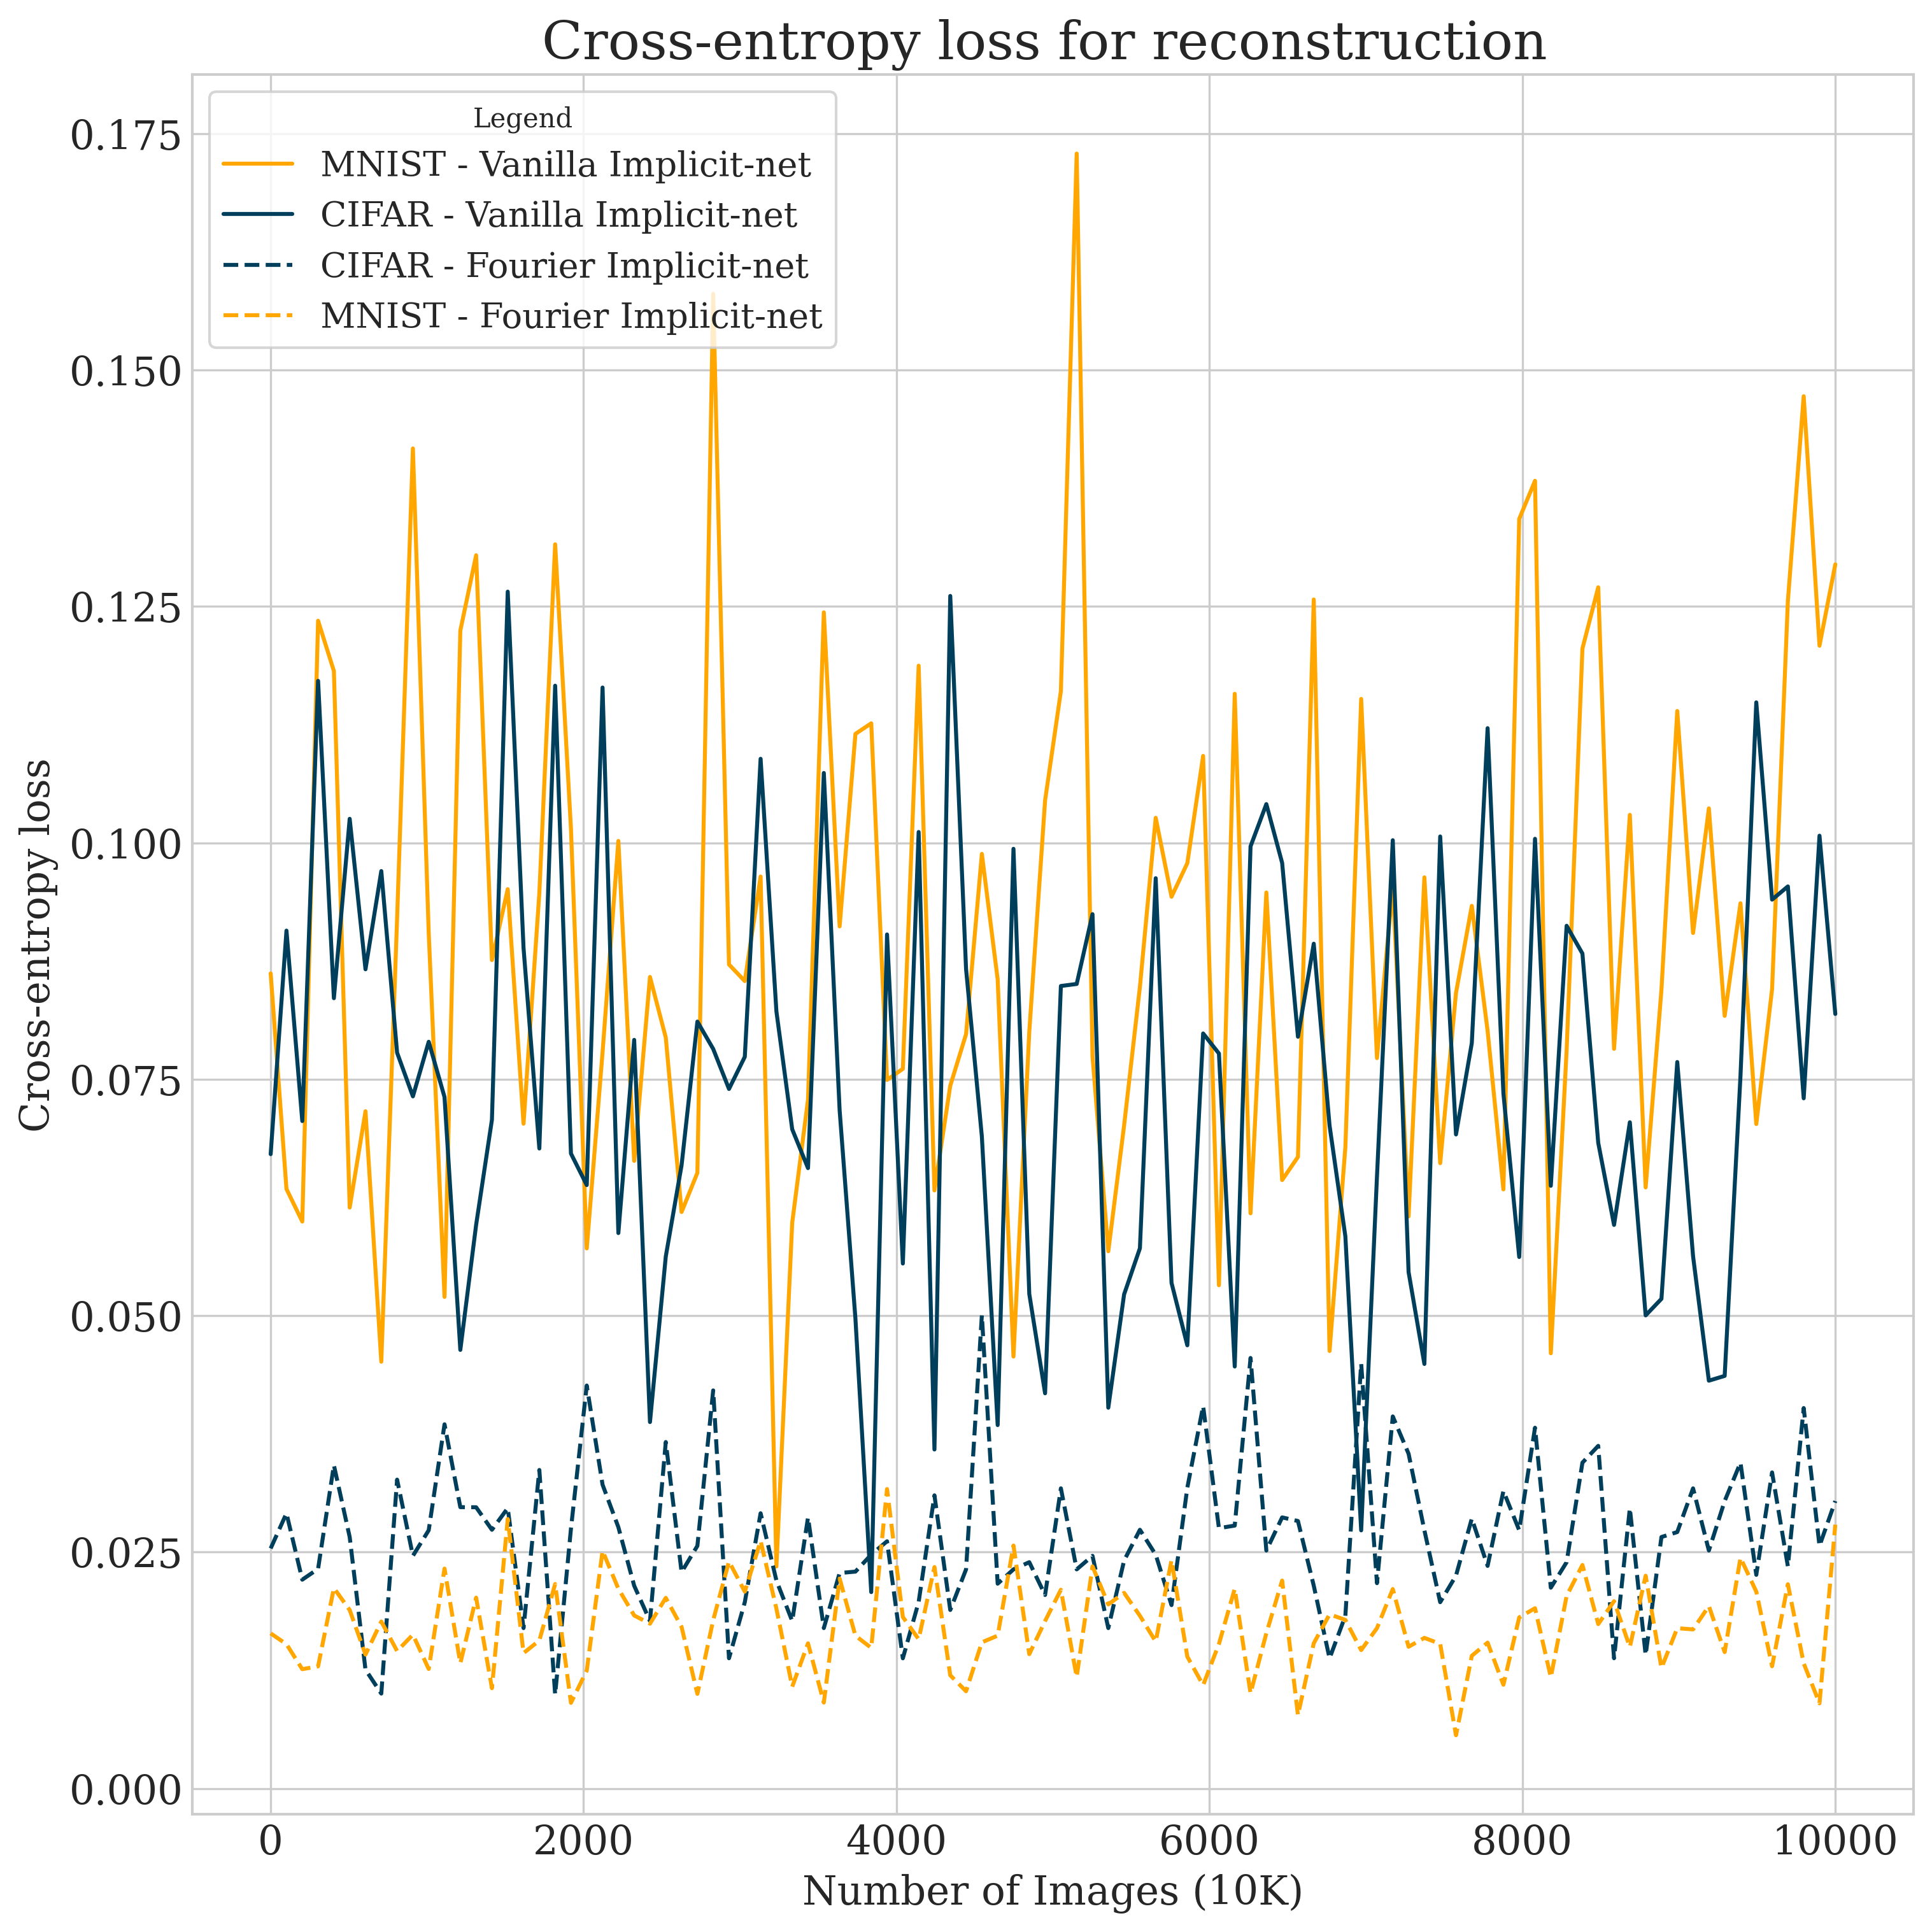

In [75]:

fig, ax = plt.subplots(layout='constrained',figsize=(10, 10),dpi=300)

ax.set_prop_cycle(linestyle=['-','-','--','--'],color=['#ffa600','#003f5c','#003f5c','#ffa600'])

plt.plot(np.linspace(0,10000,100),random.sample(loss_mnist_vanilla,100),label = 'MNIST - Vanilla Implicit-net')
plt.plot(np.linspace(0,10000,100),random.sample(loss_cifar_vanilla,100),label = 'CIFAR - Vanilla Implicit-net')
plt.plot(np.linspace(0,10000,100),random.sample(loss_cifar_fourier,100),label = 'CIFAR - Fourier Implicit-net')
plt.plot(np.linspace(0,10000,100),random.sample(loss_mnist_fourier,100),label = 'MNIST - Fourier Implicit-net')

ax.set_ylabel('Cross-entropy loss')
ax.set_xlabel('Number of Images (10K)')
ax.set_title('Cross-entropy loss for reconstruction ')

plt.legend(title='Legend', bbox_to_anchor=(0, 1), loc='upper left',prop={'size': 13},frameon=True)
plt.savefig(r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\combined\cross_entropy_loss_small.pdf")
plt.show()

## Archive

In [ ]:
# # Code to plot trained and untrained weights

# import copy

# sd_ref = copy.deepcopy(model.state_dict()) # --> Add this before and after the training loop with different variable names and return it.

# init_weights_list = []
# trained_weights_list = []

# for param in init_weights.values():
#     init_weights_list.extend(list(torch.flatten(param.data).detach().cpu().numpy()))

# for param in trained_weights.values():
#     trained_weights_list.extend(list(torch.flatten(param.data).detach().cpu().numpy()))

# plt.imshow(np.array(init_weights_list)[:9025].reshape(95,95),cmap = 'gray')
# plt.savefig(r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\cifar\plots\Observations\Cifar_untrained_weights.pdf")
# plt.show()